In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import re

### Load Dataset

In [16]:
df = pd.read_csv("df_combined2.csv")
df['date'] = pd.to_datetime(df['date'])
df['date_of_feed'] = pd.to_datetime(df['date_of_feed'])
df['browns_amount'] = df['browns_amount'] * 1000 
df['greens_amount'] = df['greens_amount'] * 1000

### Target Moisture from Training dataset and Crop requirements

Using Target Moisture from Training dataset as values from our own sensors are too extreme

In [3]:
def classify_cn_ratio(cn_ratio_str):
    """Classify C:N ratio based on the new ranges for different plant types"""
    try:
        cn_value = int(str(cn_ratio_str).split(':')[0])
    except:
        return 'Unknown'
    
    ranges = {
        'Leafy Greens': (12.5, 17.5),
        'Fruit Veggies': (15.5, 20.5),
        'Root Vegetables': (18.5, 23.5),
        'Herbs': (21.5, 26.5),
        'Flowering Plants': (18.5, 23.5),
        'Woody Plants': (24.5, 29.5)
    }
    
    status = []
    for plant_type, (min_val, max_val) in ranges.items():
        if min_val <= cn_value <= max_val:
            status.append(plant_type)
    
    if not status:
        return 'Unbalanced'
    elif len(status) == 1:
        return f'Optimal for {status[0]}'
    else:
        return f'Optimal for multiple: {", ".join(status)}'

# Update the C_N_Status column with the new classification
df['C_N_Status'] = df['C_N_Ratio'].apply(classify_cn_ratio)

In [4]:
crop_requirements = {
    "Leafy Greens": {
        "moisture": 57.75,
        "cn_min": 12.5,
        "cn_max": 17.5
    },
    "Fruit Veggies": {
        "moisture": 41.3, 
        "cn_min": 21.5,
        "cn_max": 26.5
    },
    "Root Vegetables": {
        "moisture": 40.76,
        "cn_min": 15.5,
        "cn_max": 20.5
    },
    "Herbs": {
        "moisture": 48.28,  
        "cn_min": 21.5,
        "cn_max": 20
    },
    "Flowering Plants": {
        "moisture": 40.76,  
        "cn_min": 15,
        "cn_max": 25
    },
    "Woody Plants": {
        "moisture": 39.67,  
        "cn_min": 20,
        "cn_max": 30
    }
}

In [5]:
def get_cn_value(cn_ratio_str):
    """Extract the numeric value from C:N ratio string"""
    try:
        return int(str(cn_ratio_str).split(':')[0])
    except:
        return None

In [6]:
def is_optimal_for_crop(cn_ratio_str, target_crop):
    """Check if C:N ratio is optimal for the target crop"""
    cn_value = get_cn_value(cn_ratio_str)
    if cn_value is None:
        return False
    requirements = crop_requirements.get(target_crop)
    if not requirements:
        return False
    return requirements['cn_min'] <= cn_value <= requirements['cn_max']

### Recommended Green:Brown ratio of feed to be composted

In [7]:
def simulate_feed_from_optimal_event(greens_input_grams, target_crop_input):
    """Generate compost feed recommendation based on optimal events"""
    # Normalize crop name
    crop_input_normalized = target_crop_input.strip().lower().replace(" ", "").replace("-", "")
    crop_options = {
        "leafygreens": "Leafy Greens",
        "fruitveggies": "Fruit Veggies",
        "rootvegetables": "Root Vegetables",
        "herbs": "Herbs",
        "floweringplants": "Flowering Plants",
        "woodyplants": "Woody Plants"
    }

    if crop_input_normalized not in crop_options:
        return {"message": f"Invalid crop type: {target_crop_input}. Choose one from: {list(crop_options.values())}"}

    target_crop = crop_options[crop_input_normalized]
    target_moisture_pct = crop_requirements[target_crop]['moisture']

    # Find feeds that resulted in optimal C:N for this crop
    optimal_feeds = []
    
    # Group by device and find sequences of feed -> optimal state
    for device, device_data in df.groupby('devicename'):
        # Sort by date
        device_data = device_data.sort_values('date')
        
        # Find all optimal events for this crop
        optimal_events = device_data[
            device_data['C_N_Status'].notna() & 
            device_data['C_N_Status'].str.contains("Optimal", case=False) &
            device_data.apply(lambda row: is_optimal_for_crop(row['C_N_Ratio'], target_crop), axis=1)
        ].sort_values('date')
        
        for _, optimal_row in optimal_events.iterrows():
            # Find the feed before this optimal event
            feed_before = device_data[
                (device_data['date_of_feed'].notna()) &
                (device_data['date_of_feed'] <= optimal_row['date']) &
                (device_data['greens_amount'].notna()) &
                (device_data['browns_amount'].notna())
            ].sort_values('date_of_feed', ascending=False)
            
            if not feed_before.empty:
                feed_row = feed_before.iloc[0]
                days_to_optimal = (optimal_row['date'] - feed_row['date_of_feed']).days
                optimal_feeds.append({
                    'feed': feed_row,
                    'optimal': optimal_row,
                    'days_to_optimal': days_to_optimal,
                    'device': device
                })
    
    if not optimal_feeds:
        return {"message": f"No optimal compost recipes found for {target_crop}."}

    # Select the feed that took the median time to reach optimal
    optimal_feeds.sort(key=lambda x: x['days_to_optimal'])
    selected = optimal_feeds[len(optimal_feeds) // 2]  # Median
    
    feed_row = selected['feed']
    optimal_row = selected['optimal']
    
    # Calculate browns amount based on historical ratio
    try:
        brown_per_green = feed_row['browns_amount'] / feed_row['greens_amount']
        browns_amount = greens_input_grams * brown_per_green
        
        # Calculate water needed to reach target moisture
        water_target = (target_moisture_pct / 100) * (greens_input_grams + browns_amount) / (1 - target_moisture_pct / 100)
        
        return {
            "Greens (g)": round(greens_input_grams, 2),
            "Browns (g)": round(browns_amount, 2),
            "Water (g)": round(water_target, 2),
            "Target Crop": target_crop,
            "Resulting C:N Ratio": optimal_row['C_N_Ratio'],
            "Days to Optimal": selected['days_to_optimal'],
            "Based on Device": selected['device'],
            "Based on Feed Date": feed_row['date_of_feed'].strftime('%Y-%m-%d'),
            "Observed Optimal Date": optimal_row['date'].strftime('%Y-%m-%d'),
            "Moisture Target %": target_moisture_pct
        }
    except Exception as e:
        return {"message": f"Error calculating recommendation: {str(e)}"}

### User input and output recommendation for feed

In [8]:
if __name__ == "__main__":
    print("Choose crop type: Leafy Greens | Fruit Veggies | Root Vegetables | Herbs | Flowering Plants | Woody Plants")
    crop_type = input("Enter your crop type: ")
    
    try:
        greens_input = float(input("Enter the amount of greens you have (in grams): "))
        if greens_input <= 0:
            raise ValueError("Greens amount must be positive")
            
        result = simulate_feed_from_optimal_event(greens_input, crop_type)
        
        print("\nRecommendation:")
        if 'message' in result:
            print(result['message'])
        else:
            for k, v in result.items():
                print(f"{k}: {v}")
    except ValueError as e:
        print(f"\nError: {str(e)}")

Choose crop type: Leafy Greens | Fruit Veggies | Root Vegetables | Herbs | Flowering Plants | Woody Plants
Enter your crop type: root vegetables
Enter the amount of greens you have (in grams): 30

Recommendation:
Greens (g): 30.0
Browns (g): 54.0
Water (g): 57.8
Target Crop: Root Vegetables
Resulting C:N Ratio: 16:1
Days to Optimal: 8
Based on Device: NP002
Based on Feed Date: 2025-06-30
Observed Optimal Date: 2025-07-08
Moisture Target %: 40.76


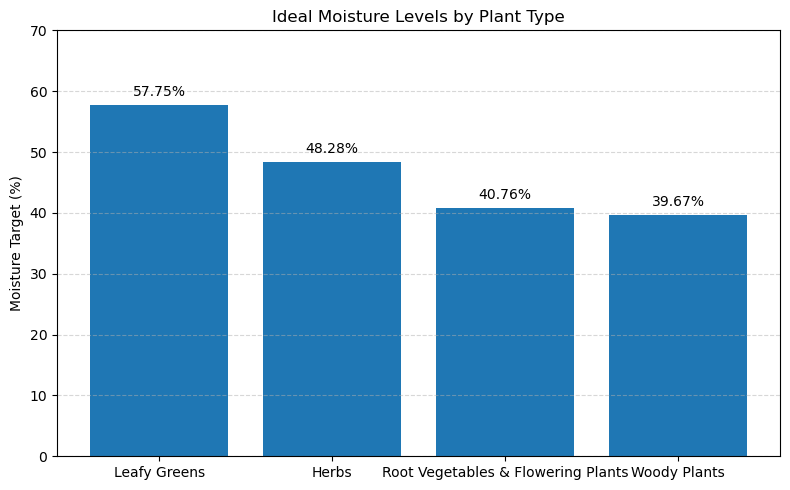

In [11]:
import matplotlib.pyplot as plt

# Moisture target values (%)
plant_types = ['Leafy Greens', 'Herbs', 'Root Vegetables & Flowering Plants', 'Woody Plants']
moisture_levels = [57.75, 48.28, 40.76, 39.67]

# Plotting
plt.figure(figsize=(8, 5))
bars = plt.bar(plant_types, moisture_levels)
plt.title('Ideal Moisture Levels by Plant Type')
plt.ylabel('Moisture Target (%)')
plt.ylim(0, 70)

# Annotate values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

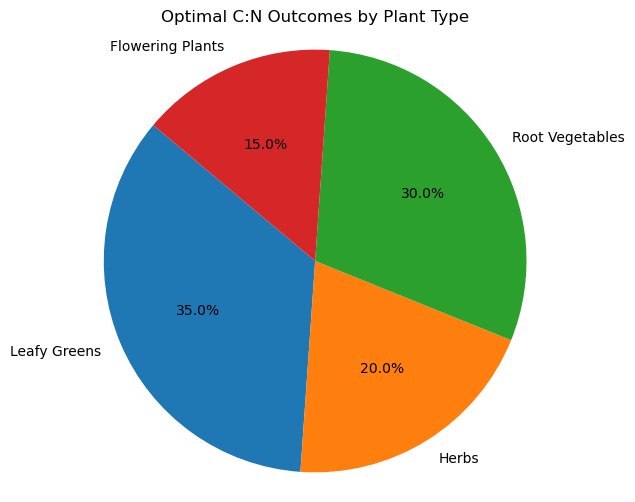

In [14]:
# Sample proportions — adjust based on your data
labels = ['Leafy Greens', 'Herbs', 'Root Vegetables', 'Flowering Plants']
optimal_counts = [35, 20, 30, 15]  # Total should add up to 100 ideally

# Plot
plt.figure(figsize=(6, 6))
plt.pie(optimal_counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Optimal C:N Outcomes by Plant Type')
plt.axis('equal')
plt.show()